In [1]:
# Julia version of the code for nonlinear filtering in Herbst and Schorfheide (2015)
# Author: Takeki Sunakawa
# Mail: takeki.sunakawa@gmail.com
# Last updated: April 19, 2019 @ Cafe de Crie, Kobe-Motomachi
# April 27, 2019 @ Ueshima Coffee, Jiyugaoka Setagaya

using DelimitedFiles
using Random
using ControlSystems # not in CoCalc
using Distributions # not in CoCalc
using PDMats # not in CoCalc
using StatsBase # not in CoCalc
using Plots
using KernelDensity
include("gensys.jl")

┌ Info: Recompiling stale cache file C:\Users\takeki\.julia\compiled\v1.1\ControlSystems\WTvAN.ji for ControlSystems [a6e380b2-a6ca-5380-bf3e-84a91bcd477e]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file C:\Users\takeki\.julia\compiled\v1.1\KernelDensity\4QyGx.ji for KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b]
└ @ Base loading.jl:1184


new_div (generic function with 1 method)

In [2]:
function model_solution(para)

# Theta = [tau kappa psi1 psi2 rA piA gammaQ rho_R rho_g rho_z sigma_R sigma_g sigma_z]
    tau     = para[1]
    kappa   = para[2]
    psi1    = para[3]
    psi2    = para[4]
    rA      = para[5]
    piA     = para[6]
    gammaQ  = para[7]
    rho_R   = para[8]
    rho_g   = para[9]
    rho_z   = para[10]
    sigma_R = para[11]
    sigma_g = para[12]
    sigma_z = para[13]
    bet = 1/(1+rA/400)

    # Equation indices

    eq_1   = 1  #** (2.1) on \hat{y}(t) **/
    eq_2   = 2  #** (2.1) on \hat{pi}(t) **/
    eq_3   = 3  #** (2.1) on \hat{R}(t) **/
    eq_4   = 4  #** \hat{y}(t-1) **/
    eq_5   = 5  #** \hat{g} process **/
    eq_6   = 6  #** \hat{z} process **/
    eq_7   = 7  #** \hat{y} expectational error **/
    eq_8   = 8  #** \hat{pi} expectational error **/

    # Variable indices 

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

    # Expectation error indices (eta) 

    ey_sh  = 1
    epi_sh = 2       

    # Shock indices (eps)

    z_sh = 1
    g_sh = 2
    R_sh = 3

    # SUMMARY

    neq  = 8
    neta = 2
    neps = 3

    # /** initialize matrices **/

    GAM0 = zeros(neq,neq)
    GAM1 = zeros(neq,neq)
       C = zeros(neq,1)        
     PSI = zeros(neq,neps)
     PPI = zeros(neq,neta)


    # =========================================================================
    #                 EQUILIBRIUM CONDITIONS: CANONICAL SYSTEM
    # =========================================================================

    # =========================================================================
    #          1. 
    # =========================================================================

    GAM0[eq_1,y_t] =  1
    GAM0[eq_1,R_t] =  1/tau
    GAM0[eq_1,g_t] = -(1-rho_g)
    GAM0[eq_1,z_t] = -rho_z/tau
    GAM0[eq_1,Ey_t1] = -1
    GAM0[eq_1,Epi_t1] = -1/tau

    # =========================================================================
    #          2. 
    # =========================================================================

    GAM0[eq_2,y_t] = -kappa;
    GAM0[eq_2,pi_t] = 1;
    GAM0[eq_2,g_t] =  kappa;
    GAM0[eq_2,Epi_t1] = -bet;

    # =========================================================================
    #          3. 
    # =========================================================================

    GAM0[eq_3,y_t] = -(1-rho_R)*psi2
    GAM0[eq_3,pi_t] = -(1-rho_R)*psi1
    GAM0[eq_3,R_t] = 1
    GAM0[eq_3,g_t] = (1-rho_R)*psi2
    GAM1[eq_3,R_t] = rho_R
    PSI[eq_3,R_sh] = 1

    # =========================================================================
    #          4. 
    # =========================================================================

    GAM0[eq_4,y1_t] = 1
    GAM1[eq_4,y_t] = 1

    # =========================================================================
    #          5. 
    # =========================================================================

    GAM0[eq_5,g_t] = 1
    GAM1[eq_5,g_t] = rho_g
    PSI[eq_5,g_sh] = 1

    # =========================================================================
    #          6. 
    # =========================================================================

    GAM0[eq_6,z_t] = 1
    GAM1[eq_6,z_t] = rho_z
    PSI[eq_6,z_sh] = 1

    # =========================================================================
    #          7. 
    # =========================================================================

    GAM0[eq_7,y_t] = 1
    GAM1[eq_7,Ey_t1] = 1
    PPI[eq_7,ey_sh] = 1

    # =========================================================================
    #          8. 
    # =========================================================================

    GAM0[eq_8,pi_t] = 1
    GAM1[eq_8,Epi_t1] = 1
    PPI[eq_8,epi_sh] = 1


    # =========================================================================
    #            QZ(generalized Schur) decomposition by GENSYS
    # =========================================================================

    T1, TC, T0, fmat, fwt, ywt, gev, eu, loose = gensys(GAM0,GAM1,C,PSI,PPI)

    return T1, T0

end

model_solution (generic function with 1 method)

In [3]:
function sysmat(T1,T0,para)

# Theta = [tau kappa psi1 psi2 rA piA gammaQ rho_R rho_g rho_z sigma_R sigma_g sigma_z]
    tau     = para[1]
    kappa   = para[2]
    psi1    = para[3]
    psi2    = para[4]
    rA      = para[5]
    piA     = para[6]
    gammaQ  = para[7]
    rho_R   = para[8]
    rho_g   = para[9]
    rho_z   = para[10]
    sigma_R = para[11]
    sigma_g = para[12]
    sigma_z = para[13]
    
    eq_y = 1
    eq_pi = 2
    eq_ffr = 3

    # /** number of observation variables **/

    ny = 3

    # /** model variable indices **/

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

    # /** shock indices **/

    z_sh = 1
    g_sh = 2
    R_sh = 3

    # =========================================================================
    #                           TRANSITION EQUATION
    #    
    #            s(t) = Phi*s(t-1) + R*e(t)
    #            e(t) ~ iid N(0,Se)
    #  
    # =========================================================================

    nep = size(T0,2)

    Phi = T1

    R   = T0

    Se  = zeros(nep,nep)

    Se[z_sh,z_sh] = (sigma_z)^2
    Se[g_sh,g_sh] = (sigma_g)^2
    Se[R_sh,R_sh] = (sigma_R)^2

    # =========================================================================
    #                           MEASUREMENT EQUATION
    #   
    #            y(t) = a + b*s(t) + u(t) 
    #            u(t) ~ N(0,HH)
    #  
    # =========================================================================

    A           = zeros(ny,1)
    A[eq_y,1]   = gammaQ
    A[eq_pi,1]  = piA
    A[eq_ffr,1] = piA+rA+4*gammaQ

    nstate = size(Phi,2)

    B = zeros(ny,nstate)

    B[eq_y,y_t]   = 1
    B[eq_y,y1_t]  = -1 
    B[eq_y, z_t]  = 1
    B[eq_pi,pi_t] = 4
    B[eq_ffr,R_t] = 4

    H = zeros(ny,ny)
    # with measurement errors (from dsge1_me.yaml)
    H[eq_y,y_t] = (0.20*0.579923)^2
    H[eq_pi,pi_t] = (0.20*1.470832)^2
    H[eq_ffr,R_t] = (0.20*2.237937)^2
    
    return A,B,H,R,Se,Phi

end

sysmat (generic function with 1 method)

In [4]:
function nearestSPD(A)

    # symmetrize A into B
    B = (A + A')/2

    # Compute the symmetric polar factor of B. Call it H.
    # Clearly H is itself SPD.
    U,Sigma,V = svd(B)
    H = V*diagm(0=>Sigma)*V'

    # get Ahat in the above formula
    Ahat = (B+H)/2

    # ensure symmetry
    Ahat = (Ahat + Ahat')/2

    p = 1
    k = 0

    while (p != 0) 
        p = 0
        try
            R = cholesky(Ahat)
        catch
            p = 1
        end    

        if (p != 0)
            k = k + 1
            mineig = -maximum(-eigvals(Ahat))
            Ahat = Ahat + (-mineig*k^2 + eps(mineig))*Matrix(1.0I,size(A,1),size(A,1))
        end

    end

    return Ahat
end

nearestSPD (generic function with 1 method)

In [5]:
function PF_lik(A, B, H, Phi, R, S2, N, yt, x0, P0, resample)

    # housekeeping
    ne        = size(S2,1)
    ns = size(B,2)
    T         = size(yt,1)
    temp = cholesky(S2)
    sqrtS2 = R*temp.U'

    # matrix for store
    all_s_up  = zeros(T,ns,N) # resampled
    lik       = zeros(T,1)
    Neff      = zeros(T,1)

    # initialization
    temp_s = x0
    temp_P = P0
    temp = cholesky(temp_P)
    s_up = repeat(temp_s,1,N) + temp.U'*randn(ns,N)
#     d = MvNormal(PDMat(H))

    weights = ones(N,1)

    yy = zeros(3,1)

    # Rest of Steps
    for tt=1:1:T

        yy[:,1] = yt[tt,:]'

        # Propagate
        s_fore = Phi*s_up + sqrtS2*randn(ne,N)

        # Un-normalized weights (naive boostrap particle filter)
        perror = repeat(yy-A,1,N) - B*s_fore
        d = MvNormal(PDMat(H))
        density = pdf(d,perror)

        # Store results
        lik[tt,1]        = log(mean(density.*weights))
        all_s_up[tt,:,:] = s_up

        # Normalize weights
        weights = (density.*weights)./(mean(density.*weights))

        # Effective sample size
        Neff[tt,1] = (N^2)/sum(weights.^2)

        if resample == 1 && Neff[tt,1] <= N/2
            s_up = s_fore[:,sample(collect(1:N),Weights(weights[:,1]),N,replace=true)] # Resampling if ESS falls below a threshold
            weights = ones(N,1)
        else
            s_up = s_fore
        end    

    end

    return lik, all_s_up, Neff
end

PF_lik (generic function with 1 method)

In [6]:
function g(Phi,sqrtS2,old_states,shocks)

#     sigma_R = para[11]
#     sigma_g = para[12]
#     sigma_z = para[13]
    
    # =========================================================================
    #                           TRANSITION EQUATION
    #    
    #            s(t) = Phi*s(t-1) + R*e(t)
    #            e(t) ~ iid N(0,Se)
    #  
    # =========================================================================

#     nep = size(T0,2)

#     Phi = T1

#     R   = T0

#     Se  = zeros(nep,nep)

#     Se[z_sh,z_sh] = (sigma_z)^2
#     Se[g_sh,g_sh] = (sigma_g)^2
#     Se[R_sh,R_sh] = (sigma_R)^2
    
#     new_states = decr(old_states,shocks,params,m.slopecon,m.coeffcn,m.coeffpn,m.coeffcb,m.coeffpb,m.np,m.ns)
    new_states = Phi*old_states + sqrtS2*shocks
    
    return new_states

end

g (generic function with 1 method)

In [7]:
function pdfy(para,yt,new_states,old_states)

    rA      = para[5]
    piA     = para[6]
    gammaQ  = para[7]

    eq_y = 1
    eq_pi = 2
    eq_ffr = 3
    
    # /** model variable indices **/

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

#     H = zeros(ny,ny)
    me = zeros(3)
    # with measurement errors (from dsge1_me.yaml)
    me[eq_y] = 0.20*0.579923
    me[eq_pi] = 0.20*1.470832
    me[eq_ffr] = 0.20*2.237937
 
	temp = 0.0
    pdf1 = 1.0

	# log gdp growth
    temp = new_states[y_t] - old_states[y_t] + gammaQ + new_states[z_t]
    temp =(1.0/me[eq_y])*(yt[eq_y]-temp)
    pdf1 = pdf1*(1.0/me[eq_y])*exp(-0.5*temp*temp)

	# log inflation (annual)
    temp = 4*new_states[pi_t] + piA
    temp = (1.0/me[eq_pi])*(yt[eq_pi]-temp)
    pdf1 = pdf1*(1.0/me[eq_pi])*exp(-0.5*temp*temp)

	# log nominal rate (annual)
    temp = 4*new_states[R_t] + piA+rA+4*gammaQ
    temp = (1.0/me[eq_ffr])*(yt[eq_ffr]-temp)
    pdf1 = pdf1*(1.0/me[eq_ffr])*exp(-0.5*temp*temp)

    pdf1 = pdf1*1.0/(sqrt(2.0*pi)^3)
    
# 	global temp = 0.0
#     global pdf1 = 1.0

#     try

# 		# log gdp growth
#         global temp = new_states[y_t] - old_states[y_t] + gammaQ + new_states[z_t]
#         global temp =(1.0/me[eq_y])*(yt[eq_y]-temp)
#         global pdf1 = pdf1*(1.0/me[eq_y])*exp(-0.5*temp*temp)

# 	    # log inflation (annual)
#         global temp = 4*new_states[pi_t] + piA
#         global temp = (1.0/me[eq_pi])*(yt[eq_pi]-temp)
#         global pdf1 = pdf1*(1.0/me[eq_pi])*exp(-0.5*temp*temp)

# 	    # log nominal rate (annual)
#         global temp = 4*new_states[R_t] + piA+rA+4*gammaQ
#         global temp = (1.0/me[eq_ffr])*(yt[eq_ffr]-temp)
#         global pdf1 = pdf1*(1.0/me[eq_ffr])*exp(-0.5*temp*temp)

#     	global pdf1 = pdf1*1.0/(sqrt(2.0*pi)^3)

# 	catch

# 		global pdf1 = 1.0e-10

# 	end

    return pdf1

end

pdfy (generic function with 1 method)

In [8]:
function PF_lik2(Phi, R, S2, para, N, yt, resample)
# explicit loop for # of particles
    
    # housekeeping
    ne        = size(S2,1)
    ns = 8 #size(B,2)
    T         = size(yt,1)
    temp = cholesky(S2)
    sqrtS2 = R*temp.U'
    
#     adjusted_proposal = zeros(T)
#     adjusted_proposal_std = ones(T)
#     adjusted_proposal_mu = zeros(T,ne)
#     adjusted_proposal[104] = 1
#     adjusted_proposal_std[104] = 1.2 # it does not matter much?
#     adjusted_proposal_mu[104,1] = -3.0 # -2.0 works poorer

    # matrix for store
    all_s_up  = zeros(T,ns,N) # resampled
    lik       = zeros(T,1)
    Neff      = zeros(T,1)

    # initialization
#     temp_s = x0
#     temp_P = P0
#     temp = cholesky(temp_P)
#     s_up = repeat(temp_s,1,N) + temp.U'*randn(ns,N)
#     d = MvNormal(PDMat(H))
    s_up = zeros(ns,N)
    s_fore = zeros(ns,N)

#     for i=1:ns
#         s_up[i,:] = zeros(1,N)
#     end

    shocks = randn(ne,N)
    for j=2:N
        s_up[:,j] = g(Phi,sqrtS2,s_up[:,j-1],shocks[:,j]) #g(m,old_local.particles[:,j-1],shocks[:,j],params)
    end

    shocks = randn(ne,N)
    for j=1:N
        s_fore[:,j] = g(Phi,sqrtS2,s_up[:,j],shocks[:,j]) #g(m,old_local.particles[:,j],shocks[:,j],params)
    end

    s_up = s_fore

    density = ones(N,1)
    weights = ones(N,1)

    yy = zeros(3,1)

    # Rest of Steps
    for tt=1:1:T

        yy[:,1] = yt[tt,:]'
        shocks = randn(ne,N)

#         if (adjusted_proposal[tt]==1)
            
#             is_sampling_std = adjusted_proposal_std[tt]
#             is_sampling_mu = adjusted_proposal_mu[tt,:]
#             shocks = is_sampling_std*shocks + repeat(is_sampling_mu',N)'
            
#         end
                    
        for i=1:N
        
            # Propagate
            s_fore[:,i] = g(Phi,sqrtS2,s_up[:,i],shocks[:,i])
#             s_fore[:,i] = Phi*s_up[:,i] + sqrtS2*randn(ne,1)

            # Un-normalized weights (naive boostrap particle filter)
#             perror = repeat(yy-A,1,N) - B*s_fore
#             perror = yy - A - B*s_fore[:,i]
#             d = MvNormal(PDMat(H))
#             temp = pdf(d,perror)
            # slow?
            temp = pdfy(para,yy,s_fore[:,i],s_up[:,i])
            density[i] = temp[1]

            # Store results
            all_s_up[tt,:,i] = s_up[:,i]
            
        end

#         if (adjusted_proposal[tt]==1)
            
#             for i=1:N

#                 kap = is_sampling_std^ne * exp(-0.5*shocks[:,i]'*shocks[:,i]) / exp(-0.5*(shocks[:,i].-is_sampling_mu)'*(shocks[:,i].-is_sampling_mu))
#                 density[i] = density[i]*kap
                
#             end
            
#         end        
        
        lik[tt,1]        = log(mean(density.*weights))
        
        # Normalize weights
        weights = (density.*weights)./(mean(density.*weights))

        # Effective sample size
        Neff[tt,1] = (N^2)/sum(weights.^2)

        if resample == 1 && Neff[tt,1] <= N/2
            s_up = s_fore[:,sample(collect(1:N),Weights(weights[:,1]),N,replace=true)] # Resampling if ESS falls below a threshold
            weights = ones(N,1)
        else
            s_up = s_fore
        end    

    end

    return lik, all_s_up, Neff
end

PF_lik2 (generic function with 1 method)

In [9]:
function KF(A,B,H,R,Se,Phi,y)
    
    # Initialize the State Vector at the Stationary Distribution
    T,l    = size(y)
    n,n    = size(Phi)
    s        = zeros(T+1,n)
    P        = zeros(T+1,n,n)
    s[1,:]   = zeros(n,1)'

    a = inv(Matrix(1.0I,n*n,n*n) - kron(Phi,Phi))*reshape(R*Se*R',n*n,1)
    P[1,:,:] = reshape(a,n,n)

    # Kalman Filter Recursion
    sprime             = zeros(n,1)
    Pprime             = zeros(n,n)
    errorprediction    = ones(T,l)
    Varerrorprediction = ones(T,l,l)
    liki               = ones(T,1)
    measurepredi       = ones(T,l)

    for i=1:T

        # Updating Step

        sprime = Phi*s[i,:]
        Pprime = Phi*P[i,:,:]*Phi' + R*Se*R'

        # Prediction Step

        yprediction = A + B*sprime

        v = y[i,:] - yprediction

        F = B*Pprime*B' + H

        kgain    = Pprime*B'*inv(F)
        s[i+1,:] = (sprime + kgain*v)'
        P[i+1,:,:] = Pprime - kgain*B*Pprime
        errorprediction[i,:] = v'
        Varerrorprediction[i,:,:] = F
        temp = 0.5*v'*inv(F)*v
        liki[i] = -0.5*l*log(2*pi) - 0.5*log(det(F)) - temp[1]
        measurepredi[i,:] = y[i,:]-v
    
    end


    statepredi = s
    varstatepredi = P

    return liki,measurepredi,statepredi,varstatepredi
end

KF (generic function with 1 method)

In [10]:
# main
# yt = readdlm("us_extended.txt")
yt = readdlm("us.txt")
# m = Model(2.09,0.98,2.25,0.65,0.34,3.16,0.51,0.81,0.98,0.93,0.19,0.65,0.24)
para = [2.09,0.98,2.25,0.65,0.34,3.16,0.51,0.81,0.98,0.93,0.19,0.65,0.24]
T1,T0 = model_solution(para)
A,B,H,R,S2,Phi = sysmat(T1,T0,para)

@time liki, measurepredi, statepredi, varstatepredi = KF(A,B,H,R,S2,Phi,yt);

  0.910670 seconds (2.41 M allocations: 117.066 MiB, 5.32% gc time)


In [11]:
rng = MersenneTwister(1234)

ns = size(B,2)
x0 = zeros(ns)
P0 = nearestSPD(dlyap(Phi,R*S2*R')) # to make it positive semidefinite

N = 40000 # number of particles 
@time lik, all_s_up, Neff = PF_lik(A, B, H, Phi, R, S2, N, yt, x0, P0, 1)
# @time lik, all_s_up, Neff = PF_lik2(Phi, R, S2, para, N, yt, 1);

  2.936704 seconds (2.74 M allocations: 1.833 GiB, 16.55% gc time)


[-306.207 -308.189]


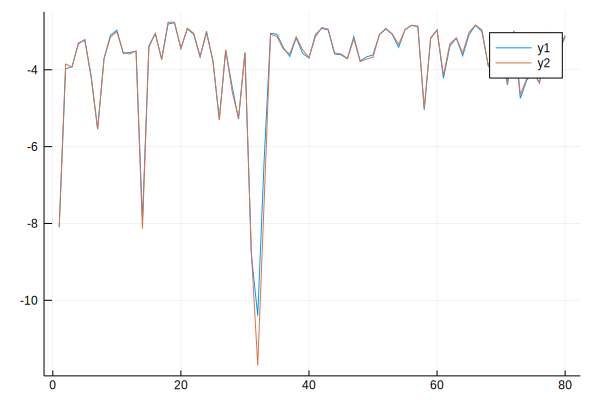

In [12]:
println([sum(liki) sum(lik)])
plot(liki)
plot!(lik)

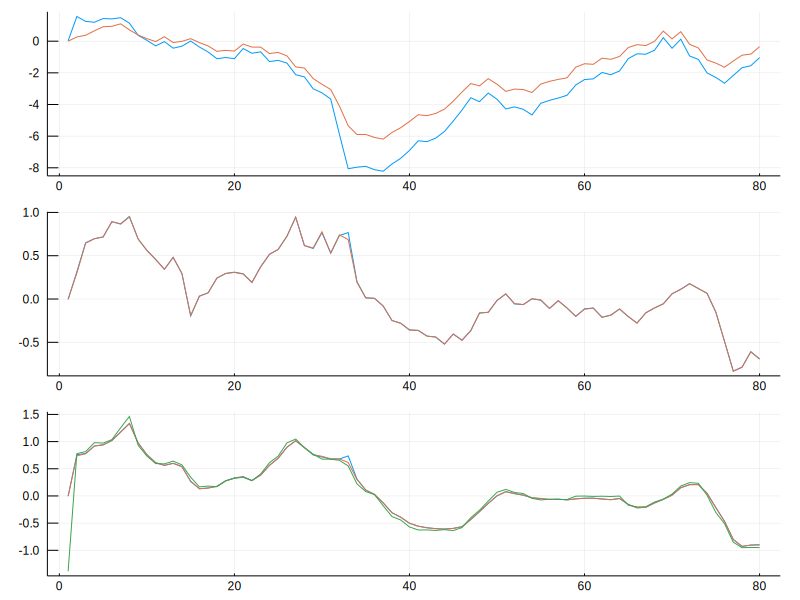

In [15]:
T = 80

rA      = para[5]
piA     = para[6]
gammaQ  = para[7]
rstar = gammaQ+piA/4+rA/4    

y1 = [mean(all_s_up[:,5,:],dims=2), statepredi[1:end-1,5]]
y2 = [mean(all_s_up[:,6,:],dims=2), statepredi[1:end-1,6]]
y3 = [mean(all_s_up[:,3,:],dims=2), statepredi[1:end-1,3], [0; yt[1:end-1,3]]/4 .- rstar]
plot(
    plot([1:T],y1),
    plot([1:T],y2),
    plot([1:T],y3),
    layout=(3,1),size=(800,600),legend=false
)

40000


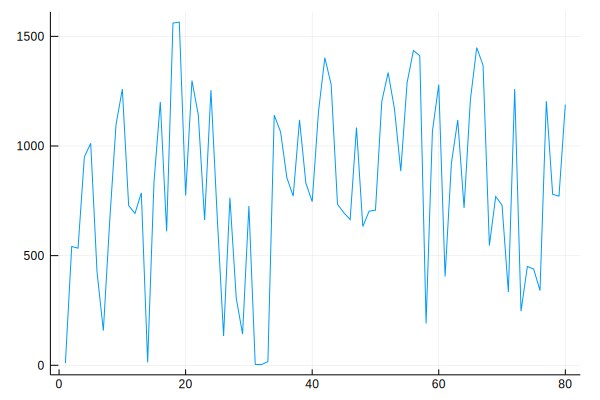

In [14]:
println(N)
plot(Neff,legend=false)

In [45]:
liki, measurepredi, statepredi, varstatepredi = KF(A,B,H,R,S2,Phi,yt)

# N_opts = [50, 100, 1000]
N_opts = [40000]

Nrep = 100

lik_store = zeros(Nrep, size(N_opts)[1])

for r = 1:Nrep
    
    for n = 1:size(N_opts)[1]
        
        N = N_opts[n]
        
        @time lik, all_s_up, Neff = PF_lik2(Phi, R, S2, para, N, yt, 1)
        
        lik_store[r,n] = sum(lik) - sum(liki)
        
    end
    
end

  4.734334 seconds (29.20 M allocations: 4.469 GiB, 18.59% gc time)
  4.700530 seconds (29.20 M allocations: 4.469 GiB, 17.73% gc time)
  4.875137 seconds (29.20 M allocations: 4.469 GiB, 18.80% gc time)
  5.052873 seconds (29.20 M allocations: 4.469 GiB, 17.48% gc time)
  4.793366 seconds (29.20 M allocations: 4.469 GiB, 18.17% gc time)
  4.663851 seconds (29.20 M allocations: 4.469 GiB, 17.84% gc time)
  4.827424 seconds (29.20 M allocations: 4.469 GiB, 18.26% gc time)
  5.016271 seconds (29.20 M allocations: 4.469 GiB, 17.97% gc time)
  4.590178 seconds (29.20 M allocations: 4.469 GiB, 18.43% gc time)
  4.549517 seconds (29.20 M allocations: 4.469 GiB, 18.34% gc time)
  4.607125 seconds (29.20 M allocations: 4.469 GiB, 18.10% gc time)
  5.312142 seconds (29.20 M allocations: 4.469 GiB, 17.04% gc time)
  5.032436 seconds (29.20 M allocations: 4.469 GiB, 19.18% gc time)
  5.209193 seconds (29.20 M allocations: 4.469 GiB, 18.79% gc time)
  5.335009 seconds (29.20 M allocations: 4.469 G

In [53]:
m = mean(lik_store,dims=1)
v = std(lik_store,dims=1)
for i = 1:1
    println([Nrep N_opts[i] m[i]+sum(liki) v[i]])
end

[100.0 40000.0 -306.447 1.95011]


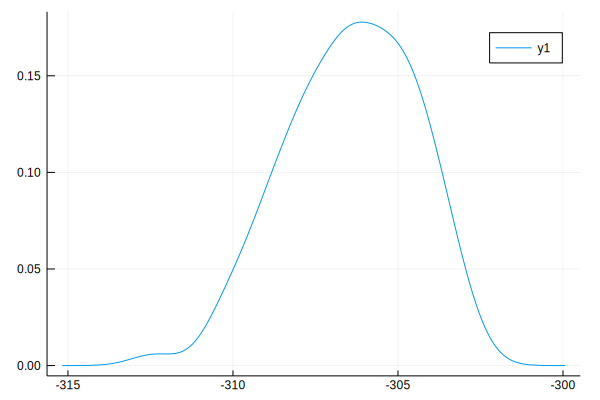

In [47]:
kd1 = kde(lik_store[:,1].+sum(liki))
# kd2 = kde(lik_store[:,2])
# kd3 = kde(lik_store[:,3])

plot(kd1.x,kd1.density)
# plot(kd2.x,kd2.density)
# plot(kd3.x,kd3.density)